In [ ]:
#General libraries
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import cv2
import os
import numpy as np
import time

from tensorflow.keras import layers
from sklearn.metrics import classification_report,confusion_matrix

#Skimage
import skimage.io as io
from skimage.transform import  rescale,resize
from skimage import exposure
from skimage.util import img_as_uint,img_as_ubyte
from skimage.color import rgb2gray

#Keras
import keras
from keras.models import Sequential
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, Adamax
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.utils import to_categorical


#Bayesian Optimization
!pip install bayesian-optimization
!pip install gpy
!pip install gpyopt
import GPy, GPyOpt

%matplotlib inline


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 959.4/959.4 kB 6.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.3/71.3 kB 8.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for gpy: filename=GPy-1.10.0-cp310-cp310-linux_x86_64.whl size=3420851 sha256=314ab2f4809be6ab89fb465654cc706495c6459afa80cfa4df6ecdcbadfe067d
  Stored in directory: /root/.cache/pip/wheels/27/bd/9f/82ab4216eae088cba864ca0dc1d75699bd4bf6823790fb2f77
  Created wheel for paramz: filename=paramz-0.9.5-py3-none-any.whl size=102543 sha256=15df4937c1fe776450e569ebbd46e0b85c9367cca9c0c9b9cc23766d673337c7
  Stored in directory: /root/.cache/pip/wheels/d2/ef/9c/da9ceef7d0ff5287c24365844fc394852c2b79ac3fcf33bf8b
Successfully built gpy paramz
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for gpyopt: filename=GPyOpt-1.2.6-py3-none-any.whl size=83588 sha

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
labels = ['Covid', 'Normal','Pneumonia']
img_size = 224
def get_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join('/content/drive/MyDrive/Đồ án cơ sở/DataSet/TrainingSet', label) #YOUR DATA PATH
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = io.imread(os.path.join(path, img))
                #img_gray = rgb2gray(img_arr)
                data.append([img_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)


In [ ]:
labels = ['Covid', 'Normal','Pneumonia']
img_size = 224
def get_dataval(data_dir):
    data = []
    for label in labels:
        path = os.path.join('/content/drive/MyDrive/Đồ án cơ sở/DataSet/ValidationSet', label) #YOUR DATA PATH
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = io.imread(os.path.join(path, img))
                #img_gray = rgb2gray(img_arr)
                data.append([img_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)


In [ ]:
labels = ['Covid', 'Normal','Pneumonia']
img_size = 224  #Por definir
def get_datatest(data_dir):
    data = []
    for label in labels:
        path = os.path.join('/content/drive/MyDrive/Đồ án cơ sở/DataSet/TestSet', label) #YOUR DATA PATH
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = io.imread(os.path.join(path, img))
                data.append([img_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [ ]:
train= get_data('/content/drive/MyDrive/Đồ án cơ sở/DataSet/TrainingSet')

In [ ]:
val= get_dataval('/content/drive/MyDrive/Đồ án cơ sở/DataSet/ValidationSet')

In [ ]:
test= get_datatest('/content/drive/MyDrive/Đồ án cơ sở/DataSet/TestSet')

Found 294 files belonging to 3 classes.


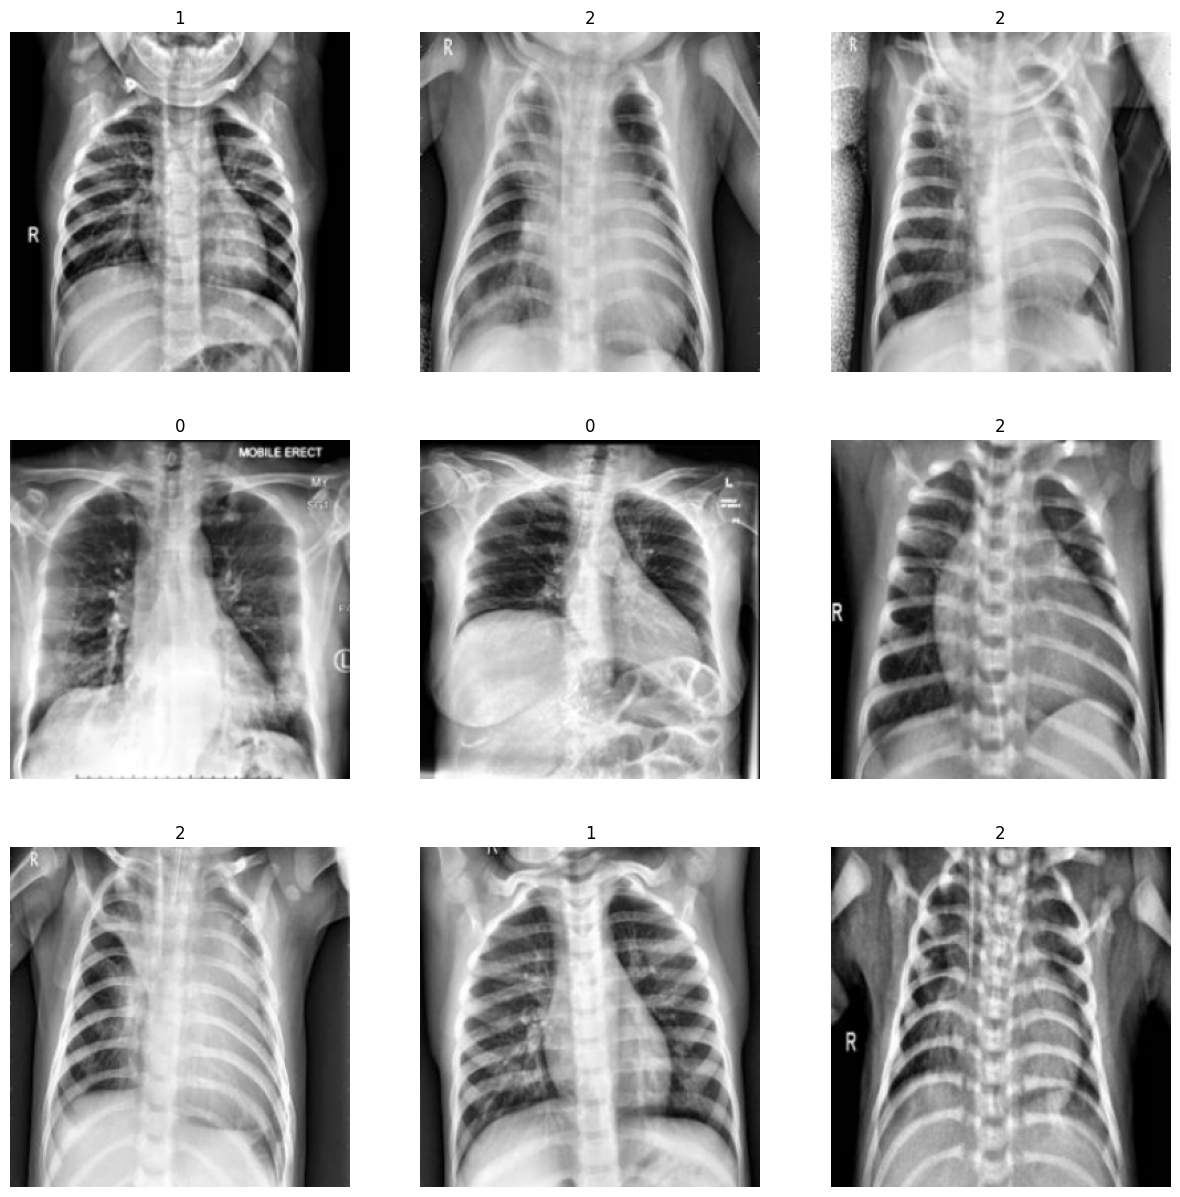

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Đồ án cơ sở/DataSet/TrainingSet")
plt.figure(figsize=(15, 15))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

#0 -> Covid
#1 -> Normal
#2 -> Pneumonia

In [ ]:
class MyCallback(keras.callbacks.Callback):
    def __init__(self, model, patience, stop_patience, threshold, factor, batches, epochs, ask_epoch):
        super(MyCallback, self).__init__()
        self.model = model
        self.patience = patience # specifies how many epochs without improvement before learning rate is adjusted
        self.stop_patience = stop_patience # specifies how many times to adjust lr without improvement to stop training
        self.threshold = threshold # specifies training accuracy threshold when lr will be adjusted based on validation loss
        self.factor = factor # factor by which to reduce the learning rate
        self.batches = batches # number of training batch to run per epoch
        self.epochs = epochs
        self.ask_epoch = ask_epoch
        self.ask_epoch_initial = ask_epoch # save this value to restore if restarting training

        # callback variables
        self.count = 0 # how many times lr has been reduced without improvement
        self.stop_count = 0
        self.best_epoch = 1   # epoch with the lowest loss
        self.initial_lr = float(tf.keras.backend.get_value(model.optimizer.lr)) # get the initial learning rate and save it
        self.highest_tracc = 0.0 # set highest training accuracy to 0 initially
        self.lowest_vloss = np.inf # set lowest validation loss to infinity initially
        self.best_weights = self.model.get_weights() # set best weights to model's initial weights
        self.initial_weights = self.model.get_weights()   # save initial weights if they have to get restored

    # Define a function that will run when train begins
    def on_train_begin(self, logs= None):
        msg = 'Do you want model asks you to halt the training [y/n] ?'
        print(msg)
        ans = input('')
        if ans in ['Y', 'y']:
            self.ask_permission = 1
        elif ans in ['N', 'n']:
            self.ask_permission = 0

        msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc', 'LR', 'Next LR', 'Monitor','% Improv', 'Duration')
        print(msg)
        self.start_time = time.time()


    def on_train_end(self, logs= None):
        stop_time = time.time()
        tr_duration = stop_time - self.start_time
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))

        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print(msg)

        # set the weights of the model to the best weights
        self.model.set_weights(self.best_weights)


    def on_train_batch_end(self, batch, logs= None):
        # get batch accuracy and loss
        acc = logs.get('accuracy') * 100
        loss = logs.get('loss')

        # prints over on the same line to show running batch count
        msg = '{0:20s}processing batch {1:} of {2:5s}-   accuracy=  {3:5.3f}   -   loss: {4:8.5f}'.format(' ', str(batch), str(self.batches), acc, loss)
        print(msg, '\r', end= '')


    def on_epoch_begin(self, epoch, logs= None):
        self.ep_start = time.time()


    # Define method runs on the end of each epoch
    def on_epoch_end(self, epoch, logs= None):
        ep_end = time.time()
        duration = ep_end - self.ep_start

        lr = float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
        current_lr = lr
        acc = logs.get('accuracy')  # get training accuracy
        v_acc = logs.get('val_accuracy')  # get validation accuracy
        loss = logs.get('loss')  # get training loss for this epoch
        v_loss = logs.get('val_loss')  # get the validation loss for this epoch

        if acc < self.threshold: # if training accuracy is below threshold adjust lr based on training accuracy
            monitor = 'accuracy'
            if epoch == 0:
                pimprov = 0.0
            else:
                pimprov = (acc - self.highest_tracc ) * 100 / self.highest_tracc # define improvement of model progres

            if acc > self.highest_tracc: # training accuracy improved in the epoch
                self.highest_tracc = acc # set new highest training accuracy
                self.best_weights = self.model.get_weights() # training accuracy improved so save the weights
                self.count = 0 # set count to 0 since training accuracy improved
                self.stop_count = 0 # set stop counter to 0
                if v_loss < self.lowest_vloss:
                    self.lowest_vloss = v_loss
                self.best_epoch = epoch + 1  # set the value of best epoch for this epoch

            else:
                # training accuracy did not improve check if this has happened for patience number of epochs
                # if so adjust learning rate
                if self.count >= self.patience - 1: # lr should be adjusted
                    lr = lr * self.factor # adjust the learning by factor
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr) # set the learning rate in the optimizer
                    self.count = 0 # reset the count to 0
                    self.stop_count = self.stop_count + 1 # count the number of consecutive lr adjustments
                    self.count = 0 # reset counter
                    if v_loss < self.lowest_vloss:
                        self.lowest_vloss = v_loss
                else:
                    self.count = self.count + 1 # increment patience counter

        else: # training accuracy is above threshold so adjust learning rate based on validation loss
            monitor = 'val_loss'
            if epoch == 0:
                pimprov = 0.0

            else:
                pimprov = (self.lowest_vloss - v_loss ) * 100 / self.lowest_vloss

            if v_loss < self.lowest_vloss: # check if the validation loss improved
                self.lowest_vloss = v_loss # replace lowest validation loss with new validation loss
                self.best_weights = self.model.get_weights() # validation loss improved so save the weights
                self.count = 0 # reset count since validation loss improved
                self.stop_count = 0
                self.best_epoch = epoch + 1 # set the value of the best epoch to this epoch

            else: # validation loss did not improve
                if self.count >= self.patience - 1: # need to adjust lr
                    lr = lr * self.factor # adjust the learning rate
                    self.stop_count = self.stop_count + 1 # increment stop counter because lr was adjusted
                    self.count = 0 # reset counter
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr) # set the learning rate in the optimizer

                else:
                    self.count = self.count + 1 # increment the patience counter

                if acc > self.highest_tracc:
                    self.highest_tracc = acc

        msg = f'{str(epoch + 1):^3s}/{str(self.epochs):4s} {loss:^9.3f}{acc * 100:^9.3f}{v_loss:^9.5f}{v_acc * 100:^9.3f}{current_lr:^9.5f}{lr:^9.5f}{monitor:^11s}{pimprov:^10.2f}{duration:^8.2f}'
        print(msg)

        if self.stop_count > self.stop_patience - 1: # check if learning rate has been adjusted stop_count times with no improvement
            msg = f' training has been halted at epoch {epoch + 1} after {self.stop_patience} adjustments of learning rate with no improvement'
            print(msg)
            self.model.stop_training = True # stop training

        else:
            if self.ask_epoch != None and self.ask_permission != 0:
                if epoch + 1 >= self.ask_epoch:
                    msg = 'enter H to halt training or an integer for number of epochs to run then ask again'
                    print(msg)

                    ans = input('')
                    if ans == 'H' or ans == 'h':
                        msg = f'training has been halted at epoch {epoch + 1} due to user input'
                        print(msg)
                        self.model.stop_training = True # stop training

                    else:
                        try:
                            ans = int(ans)
                            self.ask_epoch += ans
                            msg = f' training will continue until epoch {str(self.ask_epoch)}'
                            print(msg)
                            msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc', 'LR', 'Next LR', 'Monitor', '% Improv', 'Duration')
                            print(msg)

                        except Exception:
                            print('Invalid')

In [ ]:
def plot_training(hist):
    '''
    This function take training model and plot history of accuracy and losses with the best epoch in both of them.
    '''

    # Define needed variables
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'

    # Plot training history
    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout
    plt.show()

In [ ]:
def plot_confusion_matrix(cm, classes, normalize= False, title= 'Confusion Matrix', cmap= plt.cm.Blues):
	'''
	This function plot confusion matrix method from sklearn package.
	'''

	plt.figure(figsize= (10, 10))
	plt.imshow(cm, interpolation= 'nearest', cmap= cmap)
	plt.title(title)
	plt.colorbar()

	tick_marks = np.arange(len(classes))
	plt.xticks(tick_marks, classes, rotation= 45)
	plt.yticks(tick_marks, classes)

	if normalize:
		cm = cm.astype('float') / cm.sum(axis= 1)[:, np.newaxis]
		print('Normalized Confusion Matrix')

	else:
		print('Confusion Matrix, Without Normalization')

	print(cm)

	thresh = cm.max() / 2.
	for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
		plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

	plt.tight_layout()
	plt.ylabel('True Label')
	plt.xlabel('Predicted Label')

In [ ]:
# Create Model Structure
img_size = (224, 224,3)
class_count = 3 # to define number of classes in dense layer

# create pre-trained model (you can built on pretrained model such as :  efficientnet, VGG , Resnet )
# we will use efficientnetb3 from EfficientNet family.
base_model = tf.keras.applications.vgg19.VGG19(include_top= False, input_shape = img_size, pooling= 'max')

# additional layer
x = Flatten()(base_model.output)
x = Dropout(rate=0.2)(x)
x = Dense(256, activation='relu')(x)
outputs = Dense(class_count, activation='softmax')(x)

model = tf.keras.models.Model(base_model.input, outputs)

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

80134624/80134624 [==============================] - 4s 0us/step


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
a = np.array([[1,2],[1,2]])
b = a*3
b

array([[3, 6],
       [3, 6]])

In [ ]:
import torch
import copy
x_train = [] #Samples
y_train = [] #Labels

x_val = []  #Samples
y_val = [] #Labels

x_test = []  #Samples
y_test = [] #Labels

#TRAINING SET SAMPLES AND LABELS CREATON
for feature, label in train:
  img = copy.deepcopy(feature)
  img=torch.from_numpy(img)
  img=torch.stack([img,img,img],0)
  img=torch.transpose(img,0,2)
  img=torch.transpose(img,0,1)
  img=img.numpy()
  x_train.append(img)
  y_train.append(label)


#VALIDATION SET SAMPLES AND LABELS CREATION
for feature, label in val:
  img = copy.deepcopy(feature)
  img=torch.from_numpy(img)
  img=torch.stack([img,img,img],0)
  img=torch.transpose(img,0,2)
  img=torch.transpose(img,0,1)
  img=img.numpy()
  x_val.append(img)
  y_val.append(label)

#TEST SET SAMPLES AND LABELS CREATION
for feature, label in test:
  img = copy.deepcopy(feature)
  img=torch.from_numpy(img)
  img=torch.stack([img,img,img],0)
  img=torch.transpose(img,0,2)
  img=torch.transpose(img,0,1)
  img=img.numpy()
  x_test.append(img)
  y_test.append(label)


# NORMALIZATION
x_train = np.array(x_train)
x_val = np.array(x_val)
x_test= np.array(x_test)

#LABELS OF EACH SET
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test= np.array(y_test)

In [ ]:
batch_size = 16   # set batch size for training
epochs = 300   # number of all epochs in training
patience = 3   #number of epochs to wait to adjust lr if monitored value does not improve
stop_patience = 10   # number of epochs to wait before stopping training if monitored value does not improve
threshold = 0.9   # if train accuracy is < threshold adjust monitor accuracy, else monitor validation loss
factor = 0.5   # factor to reduce lr by
ask_epoch = 5   # number of epochs to run before asking if you want to halt training
batches = int(np.ceil(len(x_train) / batch_size))    # number of training batch to run per epoch

callbacks = [MyCallback(model= model, patience= patience, stop_patience= stop_patience, threshold= threshold,
            factor= factor, batches= batches, epochs= epochs, ask_epoch= ask_epoch )]

In [ ]:
#===========================
#TRAINING AND TESTING SHAPES
#===========================

x_train = np.reshape(x_train,(294, 224, 224, 3))
x_test = np.reshape(x_test,(63, 224, 224, 3))
y_train = to_categorical(y_train,num_classes = 3)
y_test = to_categorical(y_test,num_classes = 3)
#Training
print('x_train set shape>>>>',x_train.shape)
print('y_train set shape>>>>',y_train.shape)

#Testing
print('x_test set shape>>>>',x_test.shape)
print('y_test set shape>>>>',y_test.shape)

x_train set shape>>>> (294, 224, 224, 3)
y_train set shape>>>> (294, 3)
x_test set shape>>>> (63, 224, 224, 3)
y_test set shape>>>> (63, 3)


In [ ]:
#==========================================================
#DATA AUGMENTATION OPERATIONS WITH OPTIMAL HYPERPARAMETERS
#==========================================================
datagen = ImageDataGenerator(
        rotation_range = 190.7809510335889,
        zoom_range = 0.347686203808678,
        width_shift_range= 0.07712976589332243,
        height_shift_range= -0.04710934652942281,
        horizontal_flip = True,
        vertical_flip=False)

dgf=datagen.fit(x_train)

In [ ]:
from keras.layers import Input, Conv2D, MaxPooling2D, Dropout
from keras.layers import Dense, Flatten
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
adam_lr= 0.0002587553425186625
def createModel():
    _input = Input(shape=(224,224,3))

    conv1  = Conv2D(filters=16, kernel_size=(3,3), padding="same", activation="relu")(_input)
    conv2  = Conv2D(filters=16, kernel_size=(3,3), padding="same", activation="relu")(conv1)
    pool1  = MaxPooling2D((2, 2))(conv2)


    conv3  = SeparableConv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu")(pool1)
    conv4  = SeparableConv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu")(conv3)
    conv4  = BatchNormalization()(conv4)
    pool2  = MaxPooling2D((2, 2))(conv4)

    conv5  = SeparableConv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu")(pool2)
    conv6  = SeparableConv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu")(conv5)
    conv6  = BatchNormalization()(conv6)
    pool3  = MaxPooling2D((2, 2))(conv6)

    conv7  = SeparableConv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu")(pool3)
    conv8  = SeparableConv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu")(conv7)
    conv8 = BatchNormalization()(conv8)
    pool4  = MaxPooling2D((2, 2))(conv8)
    pool4 = Dropout(rate=0.2)(pool4)

    conv9 = SeparableConv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu")(pool4)
    conv10 = SeparableConv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu")(conv9)
    conv10 = BatchNormalization()(conv10)
    pool5  = MaxPooling2D((2, 2))(conv10)
    pool5 = Dropout(rate=0.2)(pool5)

    flat   = Flatten()(pool5)
    dense1 = Dense(512, activation="relu")(flat)
    dropout1 = Dropout(rate=0.7)(dense1)
    dense2 = Dense(128, activation="relu")(dropout1)
    dropout2 = Dropout(0.5)(dense2)
    output = Dense(3, activation="sigmoid")(dropout2)
    model  = Model(inputs=_input, outputs=output)
    model.compile(Adam(learning_rate=adam_lr),loss='binary_crossentropy',metrics=['accuracy'])

    return model

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping

early_stopping = EarlyStopping(patience=200, verbose=1,restore_best_weights=True)
modelFitLRate = createModel()
epochs = 300
batch_size = 3
history = modelFitLRate.fit(datagen.flow(
    x=x_train,
    y=y_train, batch_size=batch_size), validation_data=(x_test, y_test), callbacks = [early_stopping],epochs=epochs,verbose=1)

Epoch 1/300
98/98 [==============================] - 25s 65ms/step - loss: 0.6541 - accuracy: 0.3435 - val_loss: 0.6866 - val_accuracy: 0.3333
Epoch 2/300
98/98 [==============================] - 4s 41ms/step - loss: 0.6192 - accuracy: 0.4694 - val_loss: 0.6819 - val_accuracy: 0.3333
Epoch 3/300
98/98 [==============================] - 9s 88ms/step - loss: 0.5742 - accuracy: 0.5272 - val_loss: 0.6749 - val_accuracy: 0.3333
Epoch 4/300
98/98 [==============================] - 4s 42ms/step - loss: 0.5452 - accuracy: 0.6054 - val_loss: 0.6849 - val_accuracy: 0.3333
Epoch 5/300
98/98 [==============================] - 4s 42ms/step - loss: 0.5430 - accuracy: 0.5646 - val_loss: 0.6164 - val_accuracy: 0.6667
Epoch 6/300
98/98 [==============================] - 8s 77ms/step - loss: 0.5199 - accuracy: 0.6122 - val_loss: 0.5685 - val_accuracy: 0.7778
Epoch 7/300
98/98 [==============================] - 4s 44ms/step - loss: 0.4846 - accuracy: 0.6667 - val_loss: 0.5721 - val_accuracy: 0.4444
Epoch

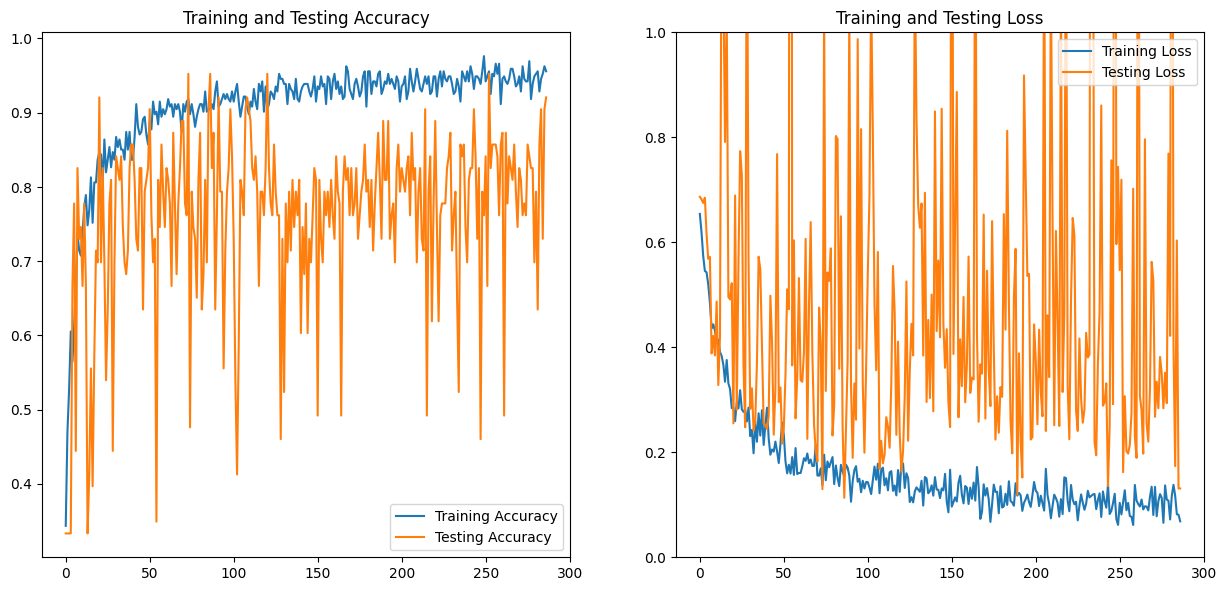

In [ ]:
#==============================
#TRAINING ANS TESTING ACCURACY
#==============================

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(287)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Testing Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Testing Accuracy')


#==============================
#TRAINING ANS TESTING LOSS
#==============================

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Testing Loss')
plt.legend(loc='upper right')
plt.title('Training and Testing Loss')
plt.ylim([0, 1])
plt.show()

In [ ]:
#==============================
#MODEL METRICS
#==============================
predict_prob=model.predict([x_test])
predict_classes=np.argmax(predict_prob,axis=1)
predictions = predict_classes.reshape(1,-1)[0]
print(classification_report(y_val, predictions, target_names = ['Covid (Class 0)','Normal (Class 1)','Pneumonia(Class 2)']))


2/2 [==============================] - 0s 192ms/step
                    precision    recall  f1-score   support

   Covid (Class 0)       1.00      0.05      0.09        21
  Normal (Class 1)       0.40      0.57      0.47        21
Pneumonia(Class 2)       0.28      0.43      0.34        21

          accuracy                           0.35        63
         macro avg       0.56      0.35      0.30        63
      weighted avg       0.56      0.35      0.30        63

